# Transformer

<img src="img/transformer.png" style="width: 45%; margin-left: auto; margin-right: auto;"/>

## Multi-Head Attention

<img src="img/multi-head-attention.png" style="width: 35%; margin-left: auto; margin-right: auto;"/>

## Scaled Dot-Product Attention

<img src="img/scaled-dot-prod-attention.png" style="width: 30%; margin-left: auto; margin-right: auto;"/>

In [1]:
!pip install transformers

In [2]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [3]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [4]:
ids = tokenizer.encode('This is an example of text, and')
ids

[1212, 318, 281, 1672, 286, 2420, 11, 290]

In [5]:
tokenizer.decode(ids)

'This is an example of text, and'

In [6]:
import torch
device = torch.device('cuda:1')
torch.cuda.set_device(device)

In [7]:
t = torch.LongTensor(ids)[None]
preds = model.generate(t)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


In [8]:
preds.shape,preds[0]

(torch.Size([1, 20]),
 tensor([1212,  318,  281, 1672,  286, 2420,   11,  290,  340,  338,  407,  257,
          922,  530,   13,  198,  198,  464,  717, 1517]))

In [9]:
tokenizer.decode(preds[0].numpy())

"This is an example of text, and it's not a good one.\n\nThe first thing"

In [10]:
from fastai.text.all import *

In [11]:
path = untar_data(URLs.WIKITEXT_TINY)
path.ls()

(#2) [Path('/home/tc/.fastai/data/wikitext-2/test.csv'),Path('/home/tc/.fastai/data/wikitext-2/train.csv')]

In [12]:
df_train = pd.read_csv(path/'train.csv', header=None)
df_valid = pd.read_csv(path/'test.csv', header=None)
df_train.head()

,0
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z..."
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re..."
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit..."
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch..."
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ...."


In [13]:
all_texts = np.concatenate([df_train[0].values, df_valid[0].values])

In [14]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [15]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [16]:
tls.train[0],tls.valid[0]

(tensor([220, 198, 796,  ..., 198, 220, 198]),
 tensor([220, 198, 796,  ..., 198, 220, 198]))

In [17]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([4576]), torch.Size([1485]))

In [18]:
bs,sl = 8,1024
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [19]:
dls.show_batch(max_n=2)

,text,text_
0,"\n = S.R. 819 = \n \n "" S.R. 819 "" is the ninth episode of the sixth season of the science fiction television series The X @-@ Files. It premiered on the Fox network on January 17, 1999 in the United States. The episode was written by John Shiban, and directed by Daniel <unk>. The episode helps to explore the series'overarching mythology. "" S.R. 819 "" earned a Nielsen household rating of 9 @.@ 1, being watched by 15 @.@ 7 million people in its initial broadcast. The episode received mixed to positive reviews from critics. \n The show centers on Federal Bureau of Investigation ( FBI ) special agents Fox Mulder ( David Duchovny ) and Dana Scully ( Gillian Anderson ) who work on cases linked to the paranormal, called X @-@ Files. Mulder is a believer in the paranormal, while the skeptical Scully has been","\n = S.R. 819 = \n \n "" S.R. 819 "" is the ninth episode of the sixth season of the science fiction television series The X @-@ Files. It premiered on the Fox network on January 17, 1999 in the United States. The episode was written by John Shiban, and directed by Daniel <unk>. The episode helps to explore the series'overarching mythology. "" S.R. 819 "" earned a Nielsen household rating of 9 @.@ 1, being watched by 15 @.@ 7 million people in its initial broadcast. The episode received mixed to positive reviews from critics. \n The show centers on Federal Bureau of Investigation ( FBI ) special agents Fox Mulder ( David Duchovny ) and Dana Scully ( Gillian Anderson ) who work on cases linked to the paranormal, called X @-@ Files. Mulder is a believer in the paranormal, while the skeptical Scully has been assigned"
1,"Fernando "" in <unk> on his left <unk>. \n \n = = Career statistics = = \n \n \n = = = Club = = = \n \n As of match played 28 May 2016. \n \n = = = International = = = \n \n As of match played 23 June 2014. \n \n = = Honours = = \n \n \n = = = Club = = = \n \n Atlético Madrid \n Segunda División : 2001 – 02 \n Chelsea \n FA Cup : 2011 – 12 \n UEFA Champions League : 2011 – 12 \n UEFA Europa League : 2012 – 13 \n \n = = = International = = = \n \n Spain <unk> \n UEFA European Under @-@ 16 Championship : 2001 \n Spain <unk> \n UEFA European Under @-@ 19 Championship : 2002 \n Spain \n UEFA European Championship : 2008, 2012",""" in <unk> on his left <unk>. \n \n = = Career statistics = = \n \n \n = = = Club = = = \n \n As of match played 28 May 2016. \n \n = = = International = = = \n \n As of match played 23 June 2014. \n \n = = Honours = = \n \n \n = = = Club = = = \n \n Atlético Madrid \n Segunda División : 2001 – 02 \n Chelsea \n FA Cup : 2011 – 12 \n UEFA Champions League : 2011 – 12 \n UEFA Europa League : 2012 – 13 \n \n = = = International = = = \n \n Spain <unk> \n UEFA European Under @-@ 16 Championship : 2001 \n Spain <unk> \n UEFA European Under @-@ 19 Championship : 2002 \n Spain \n UEFA European Championship : 2008, 2012 \n"


In [20]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [21]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [22]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [23]:
dls.show_batch(max_n=2)

,text,text_
0,"\n = HMS Hostile ( <unk> ) = \n \n HMS Hostile ( <unk> ) was an H @-@ class destroyer built for the Royal Navy in the 1930s. During the Spanish Civil War of 1936 – 1939 the ship spent considerable time in Spanish waters, enforcing the arms blockade imposed by Britain and France on both sides of the conflict. She was transferred to Freetown, Sierra Leone, in October 1939 to hunt for German commerce raiders in the South Atlantic with Force K. Hostile participated in the First Battle of Narvik in April 1940 and the Battle of <unk> in July 1940. The ship was damaged by a mine off Cape Bon in the Strait of Sicily while on passage from Malta to Gibraltar on 23 August 1940. She was then scuttled by HMS Hero. \n \n = = Description = = \n \n Hostile displaced 1 @,@","\n = HMS Hostile ( <unk> ) = \n \n HMS Hostile ( <unk> ) was an H @-@ class destroyer built for the Royal Navy in the 1930s. During the Spanish Civil War of 1936 – 1939 the ship spent considerable time in Spanish waters, enforcing the arms blockade imposed by Britain and France on both sides of the conflict. She was transferred to Freetown, Sierra Leone, in October 1939 to hunt for German commerce raiders in the South Atlantic with Force K. Hostile participated in the First Battle of Narvik in April 1940 and the Battle of <unk> in July 1940. The ship was damaged by a mine off Cape Bon in the Strait of Sicily while on passage from Malta to Gibraltar on 23 August 1940. She was then scuttled by HMS Hero. \n \n = = Description = = \n \n Hostile displaced 1 @,@ 350"
1,"framework is a meteorologist who predicts the weather. Focusing on the social <unk>, Goffman seeks to "" construct a general statement regarding the structure, or form, of experiences individuals have at any moment of their social life "". \n Goffman saw this book as his magnum opus, but it was not as popular as his earlier works. \n The Frame Analyses of Talk \n In Frame Analyses, Erving Goffman provides a platform for understanding and interpreting the interaction between individuals engaging speech communication. In the chapter “ The Frame Analyses of Talk, ” the focus is put on how words are exchanged and what is being said, specifically in informal talk or conversation. The concept of framing is introduced through an exploration of why <unk> occur in these basic, everyday conversations. He argues that they are more errors in verbal framing than anything else. The types of frames Goffman","is a meteorologist who predicts the weather. Focusing on the social <unk>, Goffman seeks to "" construct a general statement regarding the structure, or form, of experiences individuals have at any moment of their social life "". \n Goffman saw this book as his magnum opus, but it was not as popular as his earlier works. \n The Frame Analyses of Talk \n In Frame Analyses, Erving Goffman provides a platform for understanding and interpreting the interaction between individuals engaging speech communication. In the chapter “ The Frame Analyses of Talk, ” the focus is put on how words are exchanged and what is being said, specifically in informal talk or conversation. The concept of framing is introduced through an exploration of why <unk> occur in these basic, everyday conversations. He argues that they are more errors in verbal framing than anything else. The types of frames Goffman is"


In [24]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [25]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [26]:
learn.validate()

(#2) [3.2425637245178223,25.599267959594727]

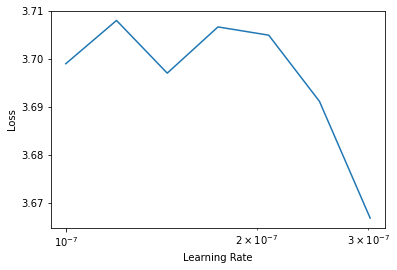

In [27]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(1, 1e-4)

RuntimeError: CUDA out of memory. Tried to allocate 1.54 GiB (GPU 1; 23.65 GiB total capacity; 19.39 GiB already allocated; 1.46 GiB free; 21.33 GiB reserved in total by PyTorch)
Exception raised from malloc at /opt/conda/conda-bld/pytorch_1595629395347/work/c10/cuda/CUDACachingAllocator.cpp:272 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x4d (0x7f696c2a977d in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x20626 (0x7f696c501626 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x214f4 (0x7f696c5024f4 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #3: <unknown function> + 0x21b81 (0x7f696c502b81 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libc10_cuda.so)
frame #4: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x249 (0x7f690ff24e39 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xd15c49 (0x7f690df45c49 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #6: <unknown function> + 0xd2fa77 (0x7f690df5fa77 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #7: <unknown function> + 0xe450dd (0x7f694436a0dd in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0xe453f7 (0x7f694436a3f7 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #9: at::empty(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0xfa (0x7f6944474e7a in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::native::empty_like(at::Tensor const&, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x49e (0x7f69440f309e in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #11: <unknown function> + 0xfe3521 (0x7f6944508521 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #12: <unknown function> + 0x101ecc3 (0x7f6944543cc3 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #13: at::empty_like(at::Tensor const&, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x101 (0x7f6944457f91 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #14: at::Tensor at::native::(anonymous namespace)::host_softmax_backward<at::native::(anonymous namespace)::LogSoftMaxBackwardEpilogue, true>(at::Tensor const&, at::Tensor const&, long, bool) + 0x16c (0x7f690f67124c in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #15: at::native::log_softmax_backward_cuda(at::Tensor const&, at::Tensor const&, long, at::Tensor const&) + 0x8d (0x7f690f64c51d in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #16: <unknown function> + 0xd038c0 (0x7f690df338c0 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #17: <unknown function> + 0xe6f636 (0x7f6944394636 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #18: at::_log_softmax_backward_data(at::Tensor const&, at::Tensor const&, long, at::Tensor const&) + 0x119 (0x7f6944422aa9 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x2c217ff (0x7f69461467ff in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #20: <unknown function> + 0xe6f636 (0x7f6944394636 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #21: at::_log_softmax_backward_data(at::Tensor const&, at::Tensor const&, long, at::Tensor const&) + 0x119 (0x7f6944422aa9 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #22: torch::autograd::generated::LogSoftmaxBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x1d7 (0x7f6945fc24b7 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #23: <unknown function> + 0x30d1017 (0x7f69465f6017 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #24: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0x1400 (0x7f69465f1860 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #25: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7f69465f2401 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #26: torch::autograd::Engine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x89 (0x7f69465ea579 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #27: torch::autograd::python::PythonEngine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x4a (0x7f694a50a1ba in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/torch/lib/libtorch_python.so)
frame #28: <unknown function> + 0xc9067 (0x7f698bd18067 in /home/tc/Programming/Python/Miniconda3/envs/ml-training/lib/python3.8/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6)
frame #29: <unknown function> + 0x9609 (0x7f698e33e609 in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #30: clone + 0x43 (0x7f698e265293 in /lib/x86_64-linux-gnu/libc.so.6)
